 # please re-start kernel if these packages are installed for the first time

In [1]:
# ! pip install -e /user/hwang/Jupyter_notebooks/pkgs/objFuncs_REA
# ! pip install -e /user/hwang/Jupyter_notebooks/pkgs/pyBO

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import datetime
import concurrent
from epics import caget

In [3]:
from objFuncs.REA_maximize_FC import maximize_FC1448 as maximize_FC
import objFuncs
from objFuncs.util import plot_obj_history
from pyBO import pyBO

[16:06:48.629] INFO: phantasy.library.operation.core: Load new machine: 'FRIB', segment: 'LINAC'
[16:06:48.630] INFO: phantasy.library.parser.config: Importing FRIB from /projects/rea3/data/CrispAnalysis/phantasy-machines/FRIB
[16:06:48.632] INFO: phantasy.library.parser.config: Loading machine configuration from /projects/rea3/data/CrispAnalysis/phantasy-machines/FRIB/phantasy.ini
[16:06:48.634] INFO: phantasy.library.operation.lattice: Loading segment: 'LINAC'
[16:06:48.670] ERROR: phantasy.library.operation.core: Cannot load machine: FRIB segment: LINAC


   _test : False
   _ensure_set_timeout : 30
   _ensure_set_timewait_after_ramp : 0.25
   _fetch_data_time_span : 2.05
   _return_obj_var : False
   _check_chopper_blocking : False


In [5]:
objFuncs._global_machineIO._test = False
objFuncs._global_machineIO._fetch_data_time_span = 2.05
objFuncs._global_machineIO._ensure_set_timewait_after_ramp : 0.25
# objFuncs._global_machineIO.fetch_data = objFuncs.construct_machineIO._manual_fetch_data
# objFuncs._global_machineIO.view()

   _test : True
   _ensure_set_timeout : 30
   _ensure_set_timewait_after_ramp : 0.25
   _fetch_data_time_span : 2.05
   _return_obj_var : False
   _check_chopper_blocking : False
   _n_popup_ramping_not_OK : 0


In [6]:
budget = 60
n_init = 40

In [7]:
ion = caget("REA_EXP:ELMT")
Q = int(caget("REA_EXP:Q"))
A = int(caget("REA_EXP:A"))
AQ = A/Q
ion = str(A)+ion+str(Q)
print(ion, 'A/Q=',AQ)

20Ne8 A/Q= 2.5


In [ ]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

In [8]:
now0str = datetime.datetime.now().strftime('%Y%m%d_%H%M')
fname = now0str+'['+ion+']'+nb_name.strip('.ipynb')
fname

'[REA][pyBO]20231208_1606_20Ne8_FC1448'

# Decision parameters and range

In [9]:
decision_CSETs = [    
#     'REA_BTS26:DCH_D1219:I_CSET',
#     'REA_BTS26:DCV_D1219:I_CSET',
    'REA_BTS30:DCH_D1305:I_CSET',
    'REA_BTS30:DCV_D1305:I_CSET',
    'REA_BTS30:DCH_D1345:I_CSET',
    'REA_BTS30:DCV_D1345:I_CSET',
#     'REA_BTS34:DCH_D1413:I_CSET',
#     'REA_BTS34:DCV_D1413:I_CSET',
#     'REA_BTS34:DCH_D1431:I_CSET',
#     'REA_BTS34:DCV_D1431:I_CSET',
#     'REA_CM01:SOL_D1123:I_CSET',
#     'REA_CM01:SOL_D1139:I_CSET'
    ]

In [10]:
decision_min = [-30]*4
decision_max = [ 30]*4
decision_tols = [0.6]*len(decision_CSETs)
print(decision_min)
print(decision_max)
print(decision_tols)

[-30, -30, -30, -30]
[30, 30, 30, 30]
[0.6, 0.6, 0.6, 0.6]


In [11]:
assert len(decision_CSETs) == len(decision_min) == len(decision_max)
if decision_tols is not None:
    assert len(decision_CSETs) == len(decision_tols) 
assert np.all(np.array(decision_min)<np.array(decision_max))

# Objectives

### manual definition of obj

In [12]:
objective_goal   = {'REA_BTS34:MTER_N0001:I_RD': {'more than': 1.0e-11}}
objective_weight = {'REA_BTS34:MTER_N0001:I_RD': 1}
objective_norm   = {'REA_BTS34:MTER_N0001:I_RD': 0.5e-11}

### regularization

In [13]:
# reg_goal = {key:0.5*(val_max+val_min) if 'PSD' in key else 0 for key,val_min,val_max in zip(decision_CSETs,decision_min,decision_max)}
# reg_norm = {key:0.5*(val_max-val_min) for key,val_min,val_max in zip(decision_CSETs,decision_min,decision_max)}
# reg_weight = {key:0.1 if 'PSD' in key else 0.05 for key in decision_CSETs}   

In [14]:
# objective_goal.update(reg_goal)
# objective_norm.update(reg_norm)
# objective_weight.update(reg_weight)

In [15]:
# pd.DataFrame((objective_goal,objective_norm,objective_weight),index=['goal','norm','weight']).T

### construct objectives class

In [16]:
obj = maximize_FC(
    decision_CSETs= decision_CSETs,
    decision_min  = decision_min,
    decision_max  = decision_max,
    decision_tols = decision_tols,
    objective_goal = objective_goal,
    objective_weight = objective_weight,
    objective_norm = objective_norm,
    objective_fill_none_by_init = True,
)

======== class info ========
init_time: 2023-12-08 16:06:49.223828
class_hierarchy: [
    maximize_FC1448, maximize_FC, objFuncGoals
    objFuncBase]
machineIO: <objFuncs.construct_machineIO.construct_machineIO object at 0x7f753edd4a90>
decision_CSETs: [
    REA_BTS30:DCH_D1305:I_CSET, REA_BTS30:DCV_D1305:I_CSET, REA_BTS30:DCH_D1345:I_CSET
    REA_BTS30:DCV_D1345:I_CSET]
decision_min: [-30. -30. -30. -30.]
decision_max: [30. 30. 30. 30.]
decision_bounds: [[-30  30]
 [-30  30]
 [-30  30]
 [-30  30]]
decision_RDs: [
    REA_BTS30:DCH_D1305:I_RD, REA_BTS30:DCV_D1305:I_RD, REA_BTS30:DCH_D1345:I_RD
    REA_BTS30:DCV_D1345:I_RD]
decision_tols: [0.6 0.6 0.6 0.6]
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: 
logging_fname: None
x0: [0. 0. 0. 0.]
objective_weight: {'REA_BTS34:MTER_N0001:I_RD': 1.0}
objective_goal: {'REA_BTS34:MTER_N0001:I_RD': {'more than': 1e-11}}
objective_norm: {'REA_BTS34:MTER_N0001:I_RD': 5e-12}
objective_RDs: [
    REA_BTS34:MTER_

 # Prepare plot callbacks

In [17]:
# define what to plot
plot_CSETs = plot_obj_history(
                obj.history['decision_CSETs'],
                title = 'decision_CSETs',
                inline = True,
                )
plot_RDs = plot_obj_history(
                obj.history['objective_RDs'],
                title = 'objective_RDs',
                inline = True,
                )
plot_objs = plot_obj_history(
            obj.history['objectives'],
            title = 'objectives',
            inline = True,
            )
callbacks = [plot_CSETs,plot_RDs,plot_objs]


# evaluate objective and plot
def obj_callbacks(x):
    return obj(x,callbacks=callbacks)

# Run BO



### run BO until budget exhaust

scipy version mismatch. 'scipy.stat.qmc' is not imported. Using custom halton seqeunce instead


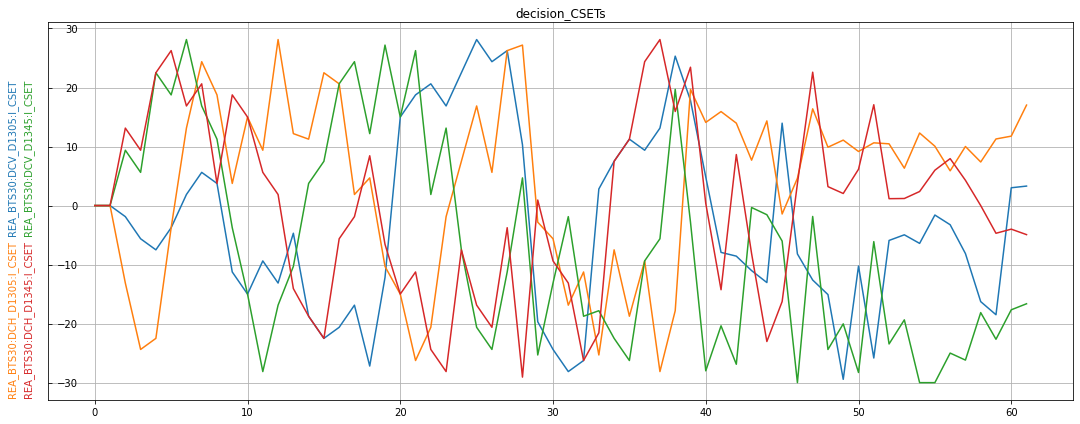

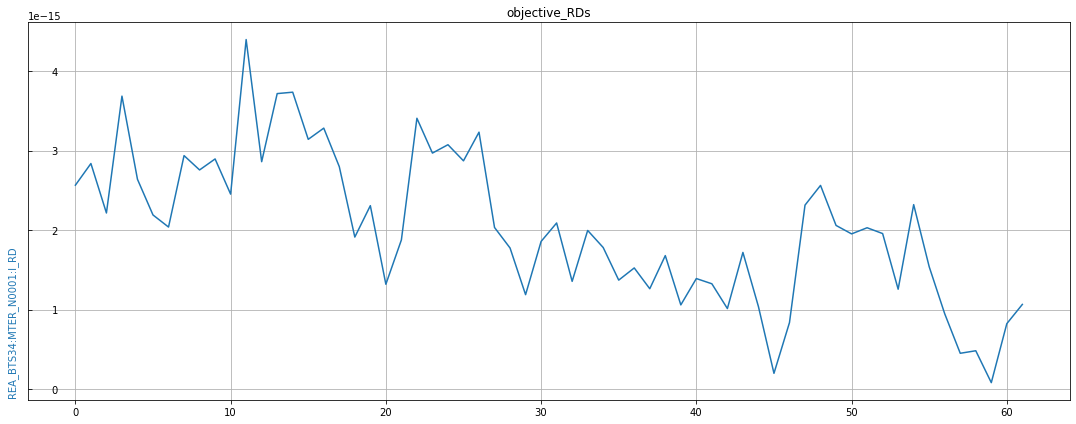

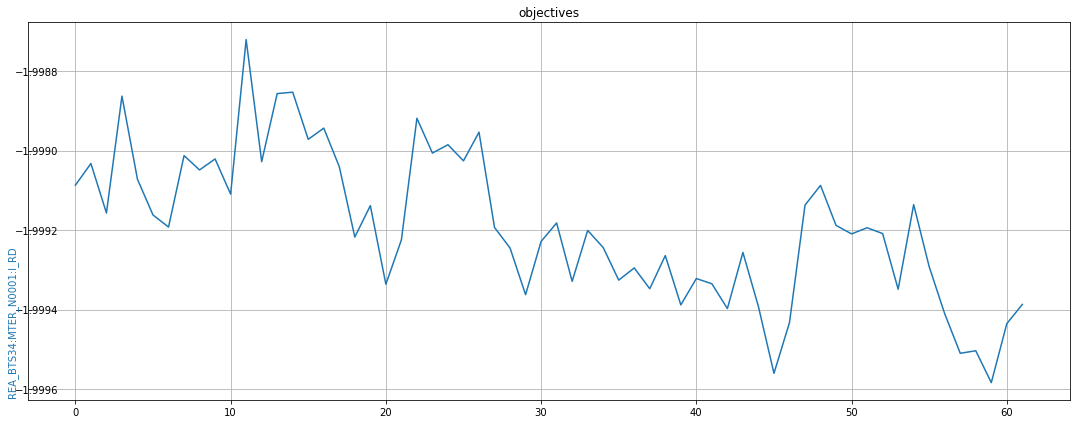

x data has duplicates. will remove duplicates and will average corresponding ys
x: [0. 0. 0. 0.] corresponding ys: [-1.99908716 -1.99903272]
[████████████████████████████████████████] 100%/100%



In [18]:
# run optimizer
bo, X_pending, Y_pending_future = pyBO.runBO(
                                    obj_callbacks,  
                                    bounds=obj.decision_bounds,
                                    n_init=n_init,
                                    x0 = obj.x0,
                                    budget = budget,
                                    batch_size=1,
                                    path="./log/",
                                    tag=fname+'_pyBO_history',
                                    write_log = False)
for f in callbacks:
    f.close()

In [19]:
# if python raised error, check the training data collected unitl now. x,y should have same number of rows 
# x = np.array(obj.history['decision_RDs']['values'])
# y = np.array(obj.history['objectives']['values'])
# print(x.shape, y.shape)

In [20]:
# if python raised error, use the following to re-use all the data until now
# bo, X_pending, Y_pending_future = pyBO.runBO(
#     obj_callbacks,  
#     bounds=obj.decision_bounds,
#     n_init=n_init,
#     x0 = np.array(obj.history['decision_RDs']['values']),
#     y0 = np.array(obj.history['objectives']['values']),
#     budget = budget,
#     batch_size=1,
#     path="./log/",
#     tag=fname+'_pyBO_history',
#     write_log = False)
# for f in callbacks:
#     f.close()

In [21]:
# # uncomment and run if more iteration needed
# X_pending, Y_pending_future= bo.loop( 
#                                 n_loop=4,  # number of additional optimization interation
#                                 func_obj = obj_callbacks,
#                                 X_pending = X_pending, 
#                                 Y_pending_future = Y_pending_future,
#                                 batch_size = 1,
#                                 write_log = False,
#                                 )
# for f in callbacks:
#     f.close()

### Fine Tune near current best

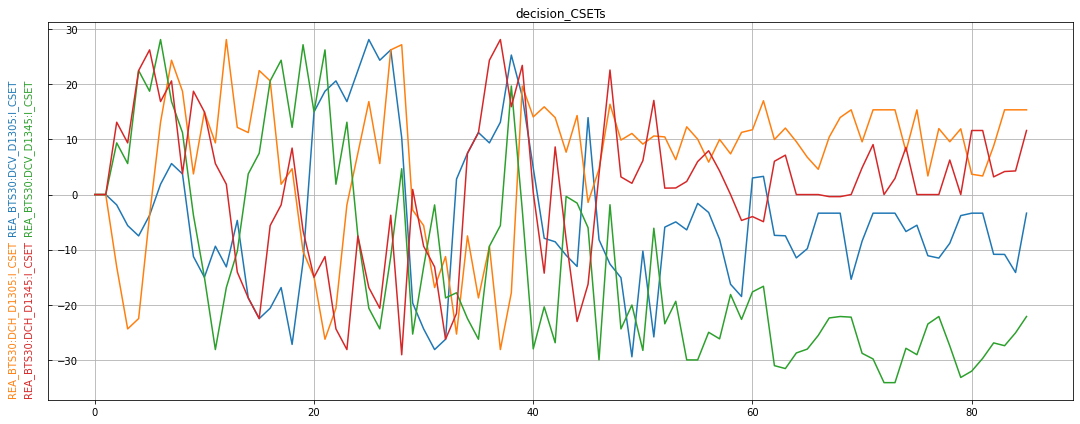

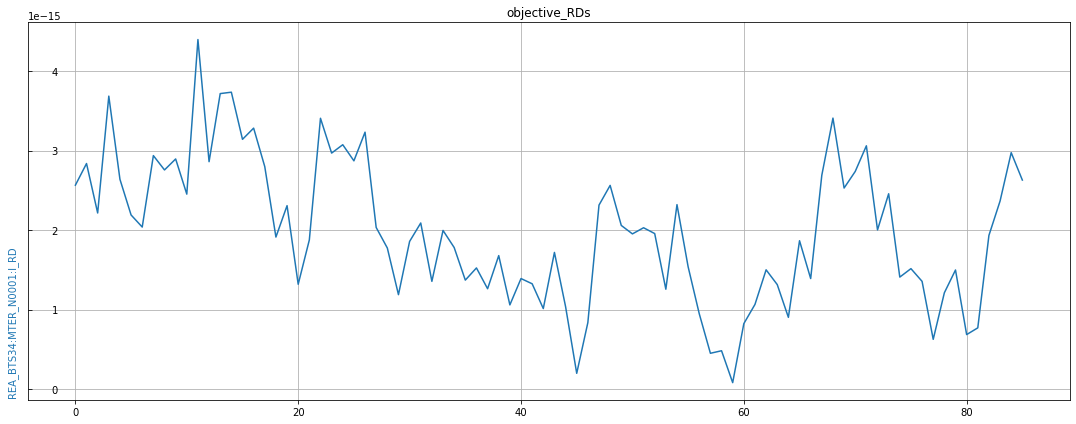

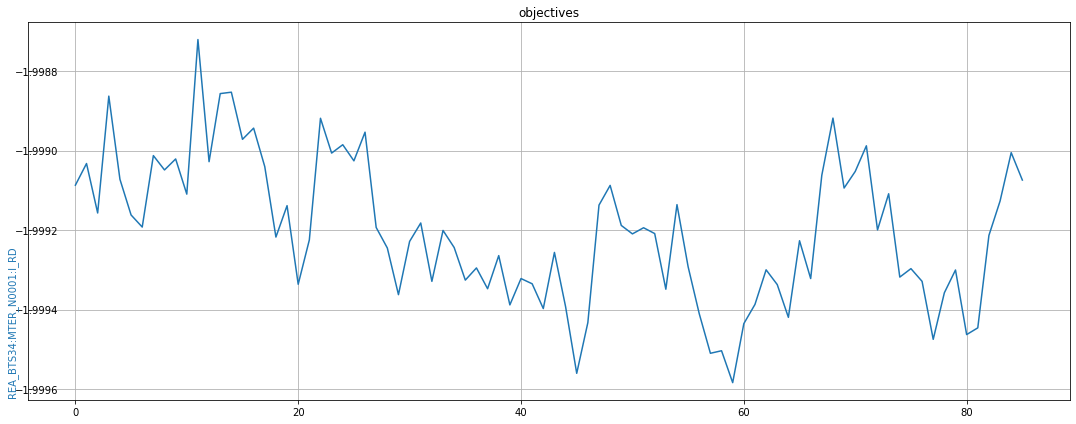

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%



In [22]:
# local optimization near the best_solution
delta = 0.1*(obj.decision_bounds[:,1]-obj.decision_bounds[:,0])
beta = 4
for i in range(3):
    x_best,y_best = bo.best_sofar()
    beta *= 0.5
    bounds_around_best = np.array([(x-d, x+d) for d, x in zip(delta,x_best)])
    acquisition_func_args = {'beta':beta}

    X_pending, Y_pending_future= bo.loop( 
                                    n_loop=8,  # number of additional optimization interation
                                    func_obj = obj_callbacks,
                                    bounds = bounds_around_best,
                                    acquisition_func_args = acquisition_func_args,
                                    X_pending = X_pending, 
                                    Y_pending_future = Y_pending_future,
                                    batch_size = 1,
                                    write_log = False,
                                    )
for f in callbacks:
    f.close()

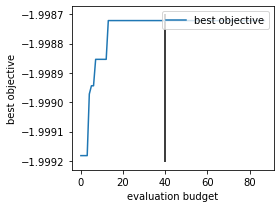

In [23]:
fig,ax = plt.subplots(figsize=(4,3))
ax = bo.plot_obj_history(ax=ax,plot_best_only=True)
ax.vlines(n_init,*ax.get_ylim(),color='k')
fig.tight_layout()
# fig.savefig(fname+'_history.png',dpi=90)

In [24]:
# set to best solution 
x_best,y_best_old = bo.best_sofar()
y_best_new = obj(x_best)
print(x_best,y_best_old[0],y_best_new)   # check if best solution objective value is consistent

[ -9.375   9.375 -28.125   5.625] -1.9987211084783045 -1.9990767288542295


In [25]:
now1 = datetime.datetime.now()
now1str = str(now1)[:str(now1).rfind(':')].replace(' ','_').replace(':','').replace('-','')
time_delta = now1 - now0
print("time took:",str(time_delta.total_seconds()/60)[:4],'min')

time took: 4.15 min


In [26]:
obj.write_log(fname=os.path.join('./log',fname))

only .pkl file extension is accepted. saving to: [REA][pyBO]20231208_1606_20Ne8_FC1448.pkl


In [27]:
# obj_ = objFuncs.objFuncGoals(
#     decision_CSETs= decision_CSETs,
#     decision_min  = decision_min,
#     decision_max  = decision_max,
#     decision_tols = decision_tols,
#     objective_goal = objective_goal,
#     objective_weight = objective_weight,
#     objective_norm = objective_norm,
#     objective_fill_none_by_init = True,
# )

# Visualize Surrogate model

In [28]:
# fixed_values_for_each_dim = {2:x_best[2],3:x_best[3]}  # fix values to visualize high dim surrogate model
fixed_values_for_each_dim = None              # do not fix values but project maximum. Can take long time to plot
batch_size = 1

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%



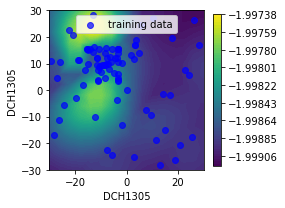

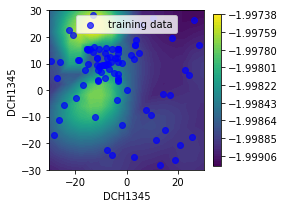

In [29]:
for i in range(int(len(decision_CSETs)/2)):
    fig,ax = plt.subplots(figsize=(4,3))
    bo.plot_model_2D_projection(project_maximum=True,
                                grid_ponits_each_dim = 16,
                                fixed_values_for_each_dim=fixed_values_for_each_dim,
                                fig=fig,ax=ax);
    ax.legend()
    pv_x = obj.decision_CSETs[2*i]
    pv_y = obj.decision_CSETs[2*i+1]
    pv_x = pv_x[pv_x.find(':')+1:]
    pv_y = pv_y[pv_y.find(':')+1:]
    pv_x = pv_x[:pv_x.find(':')].replace('_D','')
    pv_y = pv_y[:pv_y.find(':')].replace('_D','')
    ax.set_xlabel(pv_x)
    ax.set_ylabel(pv_x)
    fig.tight_layout()
#     fig.savefig(fname+'_'+pv_x+'_'+pv_y+'_.png',dpi=90)